<a href="https://colab.research.google.com/github/big-muzzy/Autoencoders/blob/master/Variational_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd

from tensorflow.keras.datasets import mnist, fashion_mnist, cifar10
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Conv2DTranspose, Input, concatenate, Reshape, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Layer
from tensorflow.keras import utils
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from tensorflow.keras.preprocessing import image # модуль для отрисовки изображения
import time



Несколько вспомогательных функций. 

Функция для вывода изображений

In [2]:
def plotImages(startIndex, imgs): # создадим функцию для вывода изображений как картинок
  n = 10  # количество картинок, которые хотим показать
  plt.figure(figsize=(20, 2)) # указываем размеры фигуры
  for i in range(n): # для каждой картинки из n(5)
      index = i + startIndex # startIndex - начиная с какого индекса хотим заплотить картинки
      # Показываем картинки
      ax = plt.subplot(1, n, i + 1) # выведем область рисования Axes
      plt.imshow(imgs[index].reshape(28, 28)) # отрисуем правильные картинки в размере 28*28
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y
  plt.show()

Функция для рисования графика обучения нейросети.

In [3]:
def plotGraph(acc, valacc):
  plt.plot(acc, label='Обучающий набор')
  plt.plot(valacc, label='Проверочный набор')
  plt.xlabel('Эпохи обучения')
  plt.ylabel('Точность')
  plt.legend()
  plt.show()

Загружаем данные - MNIST. Набор рукописных цифр.




In [4]:
(xtrain_num_org, ytrain_num_org), (xtest_num_org, ytest_num_org) = mnist.load_data()
xtrain_num = xtrain_num_org.astype(float) / 255. 
xtrain_num = xtrain_num.reshape(60000, 28, 28, 1)
xtest_num = xtest_num_org.astype(float) / 255. 
xtest_num = xtest_num.reshape(10000, 28, 28, 1)

Специальный слой для смещения точки в скрытом пространстве. Так мы научим декодер работать не с одной точкой, а с целыми облаками, и в итоге скрытое пространство будет заполнено плотнее

In [5]:
class Sampling(Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = K.shape(z_mean)[0]
    dim = K.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

Модель вариационного автокодировщика

In [6]:
def createJustDenseModel(original_dim, z_dim = 128, kld_weight = 1):
  output_dim = original_dim[0] * original_dim[1]
  model = {}

  input_img = Input(shape=original_dim, name='encoder_input')
  x = Flatten()(input_img)
  x = Dense(1024, activation='relu', name='e_Dense_1')(x)
  x = Dense(1024, activation='relu', name='e_Dense_2')(x)
  z_mean = Dense(z_dim, activation='relu', name='z_mean')(x)
  z_log_var = Dense(z_dim, activation='relu', name='z_log_var')(x)
  output_z = Sampling(name='Sampling')((z_mean, z_log_var))

  input_z = Input(shape=(z_dim,), name='latent_input')
  d = Dense(1024, activation='relu', name='d_dense_1')(input_z)
  d = Dense(1024, activation='relu', name='d_dense_2')(d)
  d = Dense(output_dim, activation='sigmoid', name='d_dense_out')(d)
  output_img = Reshape(target_shape=original_dim, name='d_Reshape')(d)

  #Собираем модели
  model['encoder'] = Model(input_img, output_z, name='encoder')
  model['z_mean'] = Model(input_img, z_mean, name='z_mean')
  model['decoder'] = Model(input_z, output_img, name='decoder')
  model['vae'] = Model(input_img, model['decoder'](model['encoder'](input_img)), name='vae')

  kl_loss = - 0.5 * K.mean(z_log_var - K.square(z_mean) - K.exp(z_log_var) + 1) * kld_weight
  model['vae'].add_loss(kl_loss)
  return model


...и функция для тестирования моделей

In [7]:
def testModel(xtrain, ytrain, xtest, ytest, zdim = 128, kld_weight = 1, createModel = createJustDenseModel):
  start = time.time()
  models = createModel(xtrain.shape[1:], z_dim=zdim, kld_weight=kld_weight)
  models['vae'].compile(optimizer='adam', loss='mse')
  history = models['vae'].fit(xtrain, ytrain, batch_size=256, epochs=32, verbose=0, validation_data=(xtest, ytest))
  print([round(val, 4) for val in history.history['val_loss']])
  plotGraph(history.history['loss'], history.history['val_loss'])
  predict = models['vae'].predict(xtest)
  plotImages(0, xtest)
  plotImages(0, predict)

  print('std:')
  z_mean_pred = models['z_mean'].predict(xtest)
  std = z_mean_pred.std(axis=0)
  print(std[:50])
  print(std.shape)

  print('time:', time.time() - start, 'sec.')

  return models



Обучение модели.

[0.0309, 0.024, 0.0213, 0.02, 0.0193, 0.0186, 0.0182, 0.0178, 0.0176, 0.0173, 0.0173, 0.0171, 0.017, 0.0168, 0.0166, 0.0166, 0.0164, 0.0164, 0.0163, 0.0162, 0.0162, 0.0161, 0.016, 0.0161, 0.0159, 0.0158, 0.0158, 0.0157, 0.0156, 0.0156, 0.0156, 0.0156]


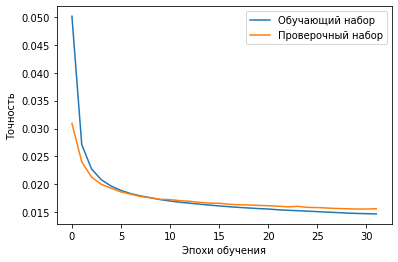

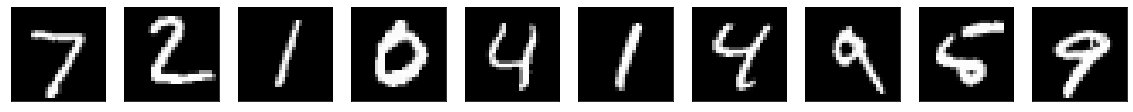

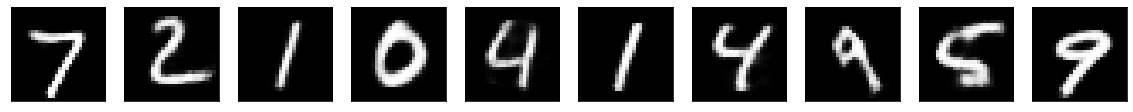

std:
[1.1567019e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.1831260e+00
 1.1413900e+00 1.2239614e+00 8.4114707e-01 9.8068976e-01 0.0000000e+00
 0.0000000e+00 1.1163032e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.2498001e+00 9.3826221e-04
 8.4802163e-01 0.0000000e+00 8.6465913e-01 0.0000000e+00 0.0000000e+00
 1.1182662e+00 9.9343383e-01 9.0916747e-01 1.1013306e+00 0.0000000e+00
 1.1370262e+00 1.0112187e+00 0.0000000e+00 9.1102034e-01 9.9129546e-01
 1.0749813e+00 9.1957045e-01 3.5214535e-04 1.1809038e+00 8.5466588e-01
 9.1891795e-01 9.0510994e-01 1.0190820e+00 1.0145726e+00 1.1173376e+00
 1.1160576e+00 1.1365709e+00 0.0000000e+00 0.0000000e+00 9.6301663e-01]
(256,)
time: 32.22363781929016 sec.


In [8]:
models = testModel(xtrain_num, xtrain_num, xtest_num, xtest_num, kld_weight=0.01, zdim=256, createModel=createJustDenseModel)


Проверка результатов. Отсортируем MNIST

In [9]:
Lens = []
for i in range(10):
  Lens.append(sum(ytest_num_org == i))
print(Lens)

xtest_n_sorted = np.empty(((sum(Lens),) + xtest_num.shape[1:]), dtype=float)
curr = 0
for i in range(10):
  print(curr, Lens[i])
  xtest_n_sorted[curr:curr + Lens[i]] = xtest_num[ytest_num_org == i][:Lens[i]]
  curr += Lens[i]

print(xtest_n_sorted.shape)

[980, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009]
0 980
980 1135
2115 1032
3147 1010
4157 982
5139 892
6031 958
6989 1028
8017 974
8991 1009
(10000, 28, 28, 1)


Выведем примеры цифр

(10, 28, 28, 1)


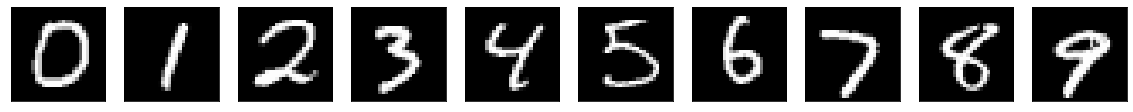

(10, 256)


In [10]:
img_org = []
st_num = 0
offset = 1
for i in Lens:
  img_org.append(xtest_n_sorted[st_num + offset])
  st_num += i

img_org = np.array(img_org)
print(img_org.shape)
plotImages(0, img_org)

img_z_mean = models['z_mean'].predict(img_org)
print(img_z_mean.shape)

Проходя по скрытому слою можно наблюдать, как одна цифра заменяется на другую.

Входные данные
(10, 28, 28, 1)


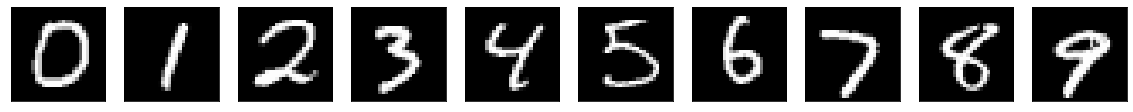

(10, 256)
Ожидаемые разультаты


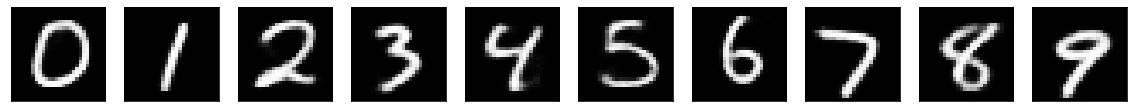

Перетекание


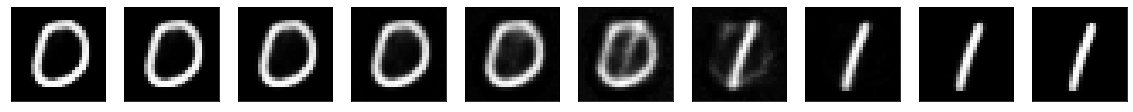

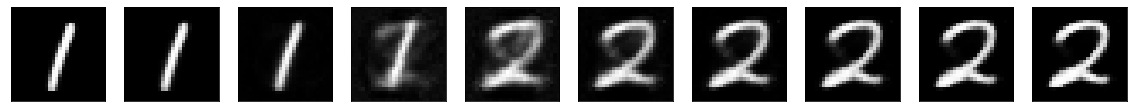

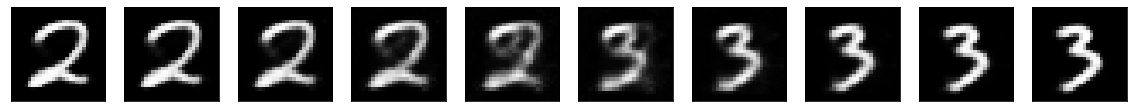

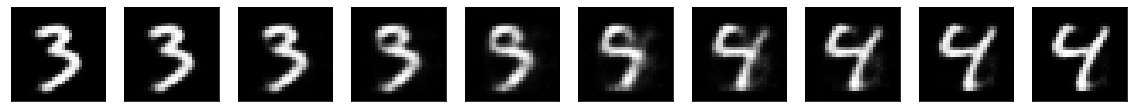

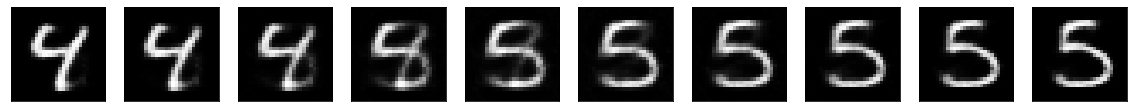

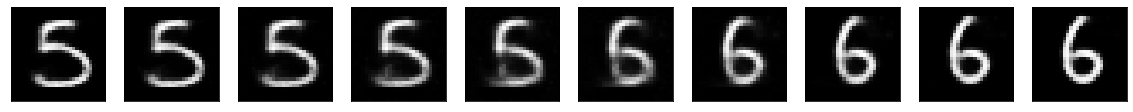

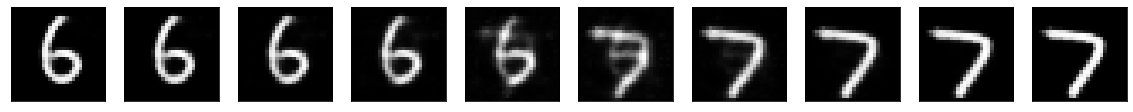

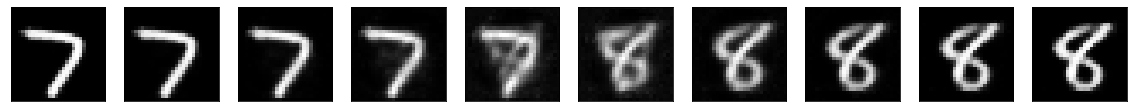

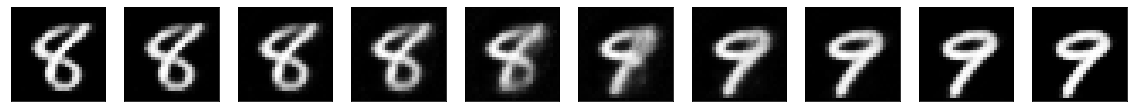

In [11]:
print('Входные данные')
print(img_org.shape)
plotImages(0, img_org)

img_z_mean = models['z_mean'].predict(img_org)
print(img_z_mean.shape)

print('Ожидаемые разультаты')
decoded_img = models['decoder'].predict(img_z_mean)
plotImages(0, decoded_img)

print('Перетекание')
for n in range(9):
  src = img_z_mean[n]
  dest = img_z_mean[n+1]
  step = (dest - src) / 9
  steps_z_mean = []
  for i in range(10):
    steps_z_mean.append(src + step * i)
  steps_z_mean = np.array(steps_z_mean)
  decoded_img = models['decoder'].predict(steps_z_mean)
  plotImages(0, decoded_img)


Плотность в скрытом слое можно регулировать изменяя коэффициент влияния KLD_LOSS.

Обучим вторую модель, с меньшим влиянием KLD

[0.0223, 0.0158, 0.0136, 0.0123, 0.0115, 0.0109, 0.0105, 0.0102, 0.01, 0.0097, 0.0095, 0.0096, 0.0093, 0.0093, 0.0092, 0.0091, 0.009, 0.0089, 0.0088, 0.0088, 0.0088, 0.0088, 0.0087, 0.0087, 0.0086, 0.0086, 0.0086, 0.0086, 0.0085, 0.0086, 0.0085, 0.0086]


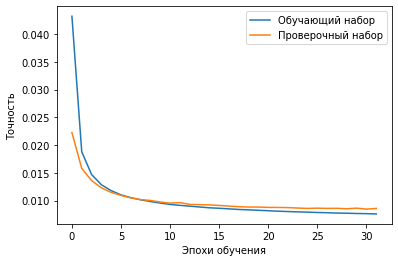

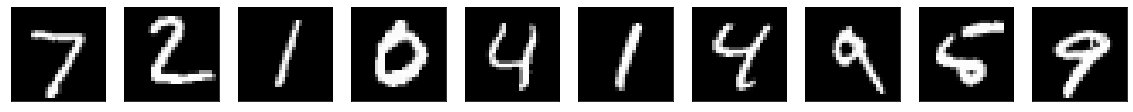

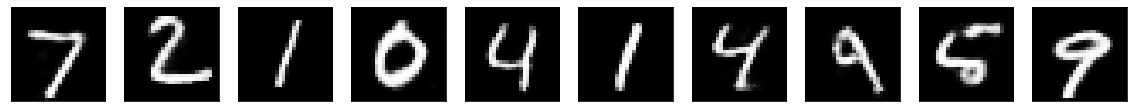

std:
[2.2614596 2.3400915 1.9220805 0.        2.340911  0.        1.6881558
 1.8117559 1.7146523 1.9537354 0.        1.8167061 1.7317556 2.2186406
 0.        1.9570241 2.02089   2.5908222 0.        1.8387203 1.4963491
 1.6692985 0.        0.        1.9385244 2.1448822 1.9456854 2.014812
 1.8430096 0.        2.1003087 2.0554073 2.9310591 0.        2.2862887
 2.1178834 2.2518222 2.146483  1.865349  2.1325731 0.        2.2534304
 2.0086179 1.7492347 1.8849537 0.        1.9216423 0.        1.7175963
 0.       ]
(256,)
time: 31.179842233657837 sec.


In [12]:
models = testModel(xtrain_num, xtrain_num, xtest_num, xtest_num, kld_weight=0.001, zdim=256, createModel=createJustDenseModel)


...и посмотрим что получилось.

Перетекание должно быть плавнее. 

Входные данные
(10, 28, 28, 1)


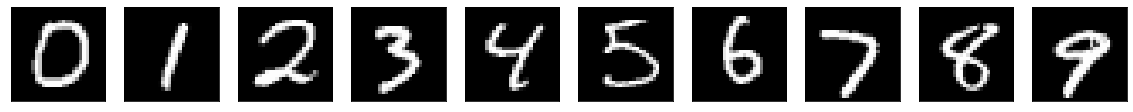

(10, 256)
Ожидаемые разультаты


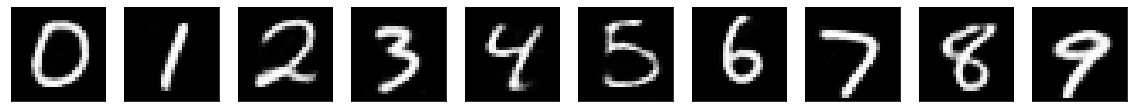

Перетекание


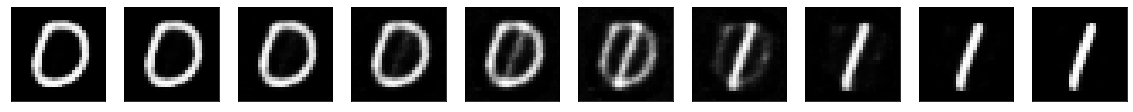

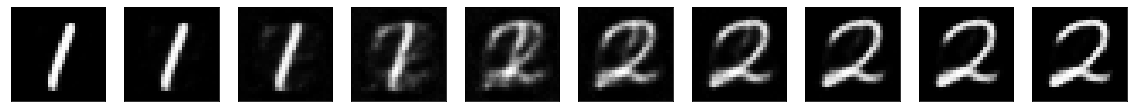

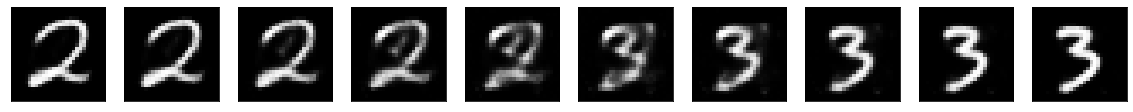

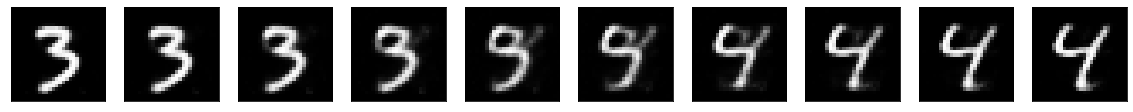

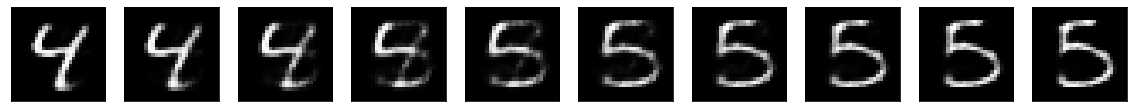

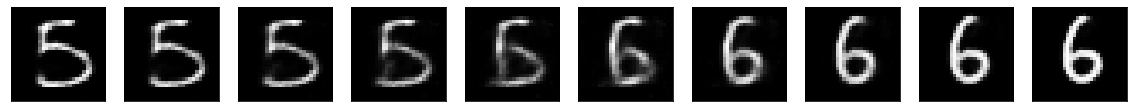

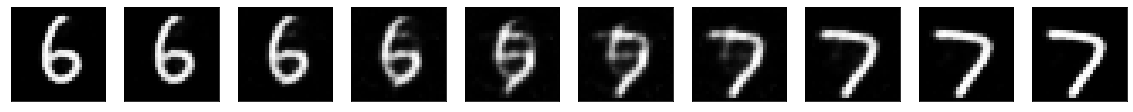

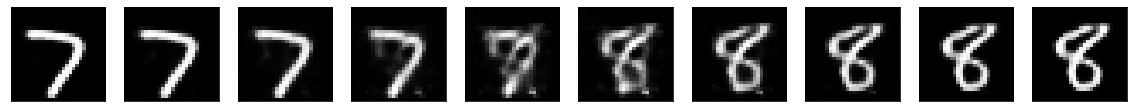

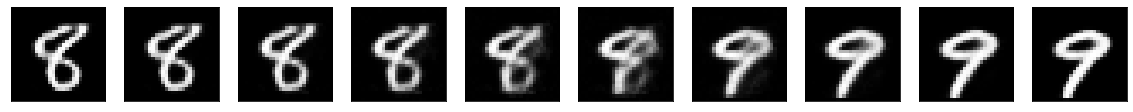

In [13]:
print('Входные данные')
print(img_org.shape)
plotImages(0, img_org)

img_z_mean = models['z_mean'].predict(img_org)
print(img_z_mean.shape)

print('Ожидаемые разультаты')
decoded_img = models['decoder'].predict(img_z_mean)
plotImages(0, decoded_img)

print('Перетекание')
for n in range(9):
  src = img_z_mean[n]
  dest = img_z_mean[n+1]
  step = (dest - src) / 9
  steps_z_mean = []
  for i in range(10):
    steps_z_mean.append(src + step * i)
  steps_z_mean = np.array(steps_z_mean)
  decoded_img = models['decoder'].predict(steps_z_mean)
  plotImages(0, decoded_img)
